In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

In [3]:
def mse(true, pred):
    return np.mean((pred - true) ** 2)

def mse_derivative(true, pred):
    return 2 * (pred - true) / true.size

In [4]:
def standarize(data, train_mean, train_std):
    return (data - train_mean) / train_std

def min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [5]:
class MLP:
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        self.w_ih = np.random.randn(input_dimension, hidden_dimension) * 0.01
        self.w_ho = np.random.randn(hidden_dimension, output_dimension) * 0.01
        
        self.b_h = np.zeros((1, hidden_dimension))
        self.b_o = np.zeros((1, output_dimension))

    def forward(self, x):
        self.x = x

        z = x @ self.w_ih + self.b_h
        a = relu(z)
        y_pred = a @ self.w_ho + self.b_o

        cache = (z, a)

        return y_pred, cache
    
    def backward(self, y_true, y_pred, cache, learning_rate):
        z, a = cache
        dy = mse_derivative(y_true, y_pred)

        dw_ho = a.T @ dy
        db_o = np.sum(dy, axis=0, keepdims=True)

        da = dy @ self.w_ho.T
        dz = da * relu_derivative(z)

        dw_ih = self.x.T @ dz
        db_h = np.sum(dz, axis=0, keepdims=True)

        self.w_ih -= learning_rate * dw_ih
        self.w_ho -= learning_rate * dw_ho
        self.b_h -= learning_rate * db_h
        self.b_o -= learning_rate * db_o

    def train(self, x, y, epochs, learning_rate):
        loss_list = []

        for epoch in range(epochs):
            epoch_loss = 0

            y_pred, cache = self.forward(x)
            self.backward(y, y_pred, cache, learning_rate)

            loss = mse(y, y_pred)
            epoch_loss += loss
            loss_list.append(epoch_loss / x.shape[0])
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Loss: {loss}')

        return loss_list
    
    def metrics(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)

        r_square = 1 - (ss_residual / ss_total)
        rmse = np.sqrt(mse(y_true, y_pred))
        mae = np.mean(np.abs(y_true - y_pred))
        mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

        print(f'R-Square: {r_square:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'MAPE: {mape:.4f}')
        

In [6]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)

x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']
x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

In [7]:
input_dimension = x_train.shape[1]
hidden_dimension = 64
output_dimension = y_train.shape[1]

mlp_model = MLP(
    input_dimension=input_dimension, 
    hidden_dimension=hidden_dimension, 
    output_dimension=output_dimension, 
)

Epoch 100, Loss: 0.07602766124481382
Epoch 200, Loss: 0.03430066795876635
Epoch 300, Loss: 0.03019452242285108
Epoch 400, Loss: 0.02794608142110004
Epoch 500, Loss: 0.026241867201164705
Epoch 600, Loss: 0.024797873536057505
Epoch 700, Loss: 0.02351161426715134
Epoch 800, Loss: 0.02232024530027518
Epoch 900, Loss: 0.021193461315256165
Epoch 1000, Loss: 0.0201228529140906


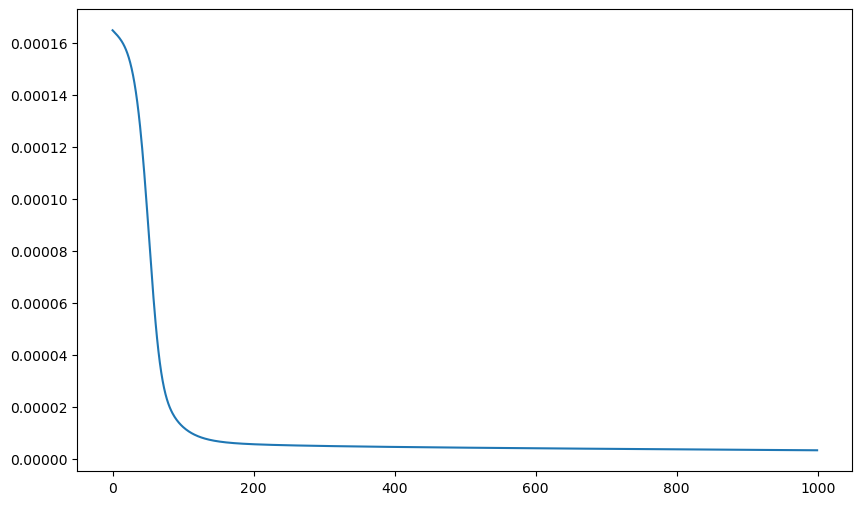

In [8]:
loss_list = mlp_model.train(x_train, y_train, epochs=1000, learning_rate=0.01)

plt.figure(figsize=(10, 6))
plt.plot(loss_list)
plt.show()

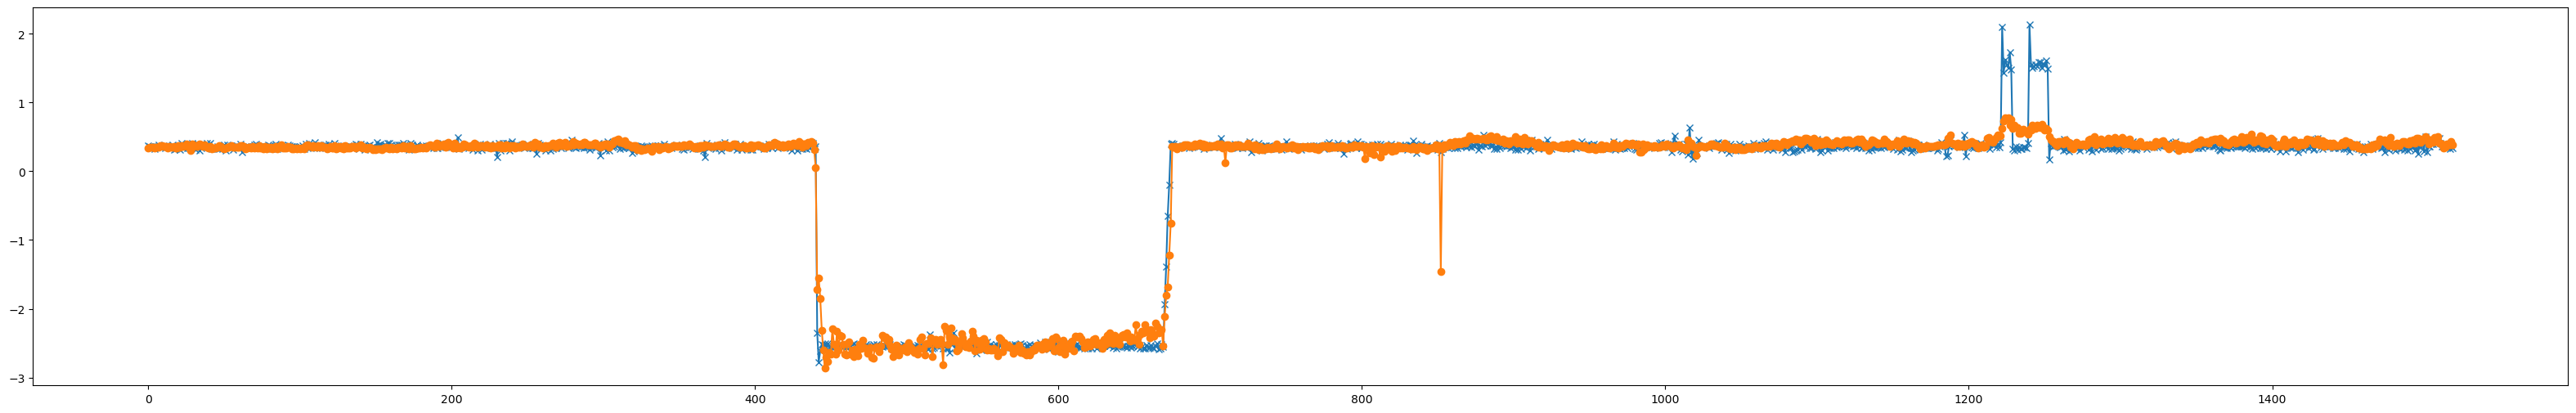

In [9]:
y_pred, _ = mlp_model.forward(x_test_sorted)

plt.figure(figsize=(40, 6))
plt.plot(y_test_sorted, marker='x')
plt.plot(y_pred, marker='o')
plt.show()

In [10]:
mlp_model.metrics(y_test_sorted, y_pred)

R-Square: 0.9789
RMSE: 0.1536
MAE: 0.0692
MAPE: 11.1887
